In [1]:
# (Run this only in Colab or if packages missing)
# !pip install wordcloud scikit-learn matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter


In [2]:
csv_path = "https://raw.githubusercontent.com/Wahid-vinchenzo/Research-Farm/refs/heads/main/AGrimid/Data%20set%20Agrimid/dummy_ai_preference_dataset.csv"
# uploaded PDF path (for reference)
pdf_path = "/mnt/data/Research Proposal (2).pdf"

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Loaded dataset:", csv_path)
else:
    print("CSV not found. Creating demo dataset (10 rows).")
    data = [
        {
            "participant_id": f"P{i:02d}",
            "age": [21,22,23,24,25,26,27,28,29,30][i-1],
            "gender": ["Male","Female","Male","Female","Male","Female","Male","Male","Female","Female"][i-1],
            "role": ["Student","Student","Teacher","Student","Office Staff","Teacher","Student","Office Staff","Teacher","Student"][i-1],
            "familiarity_ai": [3,4,2,3,5,4,2,3,4,5][i-1],
            "general_trust_ai": [3,4,2,3,4,3,2,3,4,5][i-1],
            "comfort_scheduling": [4,5,3,4,5,4,3,4,5,5][i-1],
            "comfort_grading_mcq": [3,4,2,3,4,3,2,3,4,5][i-1],
            "comfort_grading_essay": [2,3,1,2,3,2,1,2,3,4][i-1],
            "risk_scheduling": [2,1,3,2,1,2,3,2,1,1][i-1],
            "risk_grading_mcq": [3,2,4,3,2,3,4,3,2,1][i-1],
            "need_human_essay": [5,4,5,5,4,5,5,4,5,3][i-1],
            "task_pref_sensitive": [
                "Hiring decisions",
                "Financial approval",
                "Student final grading",
                "Medical suggestions",
                "Salary calculation",
                "Student emotional feedback",
                "Creative writing grading",
                "Legal decisions",
                "Performance evaluation",
                "Final academic evaluation"
            ][i-1],
            "task_routine_automate": [
                "Email sorting; Scheduling meetings",
                "Note summarizing; MCQ grading",
                "Draft generation; Scheduling",
                "Summaries; Routine research tasks",
                "Inventory checks; Emails",
                "Lecture transcription; Scheduling",
                "Grammar correction; MCQ grading",
                "Report formatting; Email sorting",
                "Data entry; Scheduling",
                "Research summarization; Email filtering"
            ][i-1],
            "concerns_top3": [
                "Accuracy; Bias; Privacy",
                "Privacy; Over-automation; Job loss",
                "Bias; Accountability; Accuracy",
                "Misinterpretation; Privacy; Safety",
                "Data misuse; Reliability; Accuracy",
                "Bias; Emotional understanding; Fairness",
                "Bias; Misgrading; Context loss",
                "Accountability; Errors; Privacy",
                "Accuracy; Transparency; Bias",
                "Fairness; Context; Reliability"
            ][i-1]
        }
        for i in range(1, 11)
    ]
    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)
    print("Saved demo dataset to:", csv_path)

df.head()


CSV not found. Creating demo dataset (10 rows).
Saved demo dataset to: https://raw.githubusercontent.com/Wahid-vinchenzo/Research-Farm/refs/heads/main/AGrimid/Data%20set%20Agrimid/dummy_ai_preference_dataset.csv


,participant_id,age,gender,role,familiarity_ai,general_trust_ai,comfort_scheduling,comfort_grading_mcq,comfort_grading_essay,risk_scheduling,risk_grading_mcq,need_human_essay,task_pref_sensitive,task_routine_automate,concerns_top3
0,P01,21,Male,Student,3,3,4,3,2,2,3,5,Hiring decisions,Email sorting; Scheduling meetings,Accuracy; Bias; Privacy
1,P02,22,Female,Student,4,4,5,4,3,1,2,4,Financial approval,Note summarizing; MCQ grading,Privacy; Over-automation; Job loss
2,P03,23,Male,Teacher,2,2,3,2,1,3,4,5,Student final grading,Draft generation; Scheduling,Bias; Accountability; Accuracy
3,P04,24,Female,Student,3,3,4,3,2,2,3,5,Medical suggestions,Summaries; Routine research tasks,Misinterpretation; Privacy; Safety
4,P05,25,Male,Office Staff,5,4,5,4,3,1,2,4,Salary calculation,Inventory checks; Emails,Data misuse; Reliability; Accuracy


In [3]:
# Combine text columns we want to analyze
text_cols = ["task_routine_automate", "task_pref_sensitive", "concerns_top3"]
for c in text_cols:
    df[c] = df[c].fillna("").astype(str)

# combined text per participant
df["combined_text"] = df["task_routine_automate"].str.replace(";", " ").str.lower() + " " + \
                      df["task_pref_sensitive"].str.lower() + " " + \
                      df["concerns_top3"].str.replace(";", " ").str.lower()

# quick check
df[["participant_id","combined_text"]].head()


,participant_id,combined_text
0,P01,email sorting scheduling meetings hiring deci...
1,P02,note summarizing mcq grading financial approv...
2,P03,draft generation scheduling student final gra...
3,P04,summaries routine research tasks medical sugg...
4,P05,inventory checks emails salary calculation da...


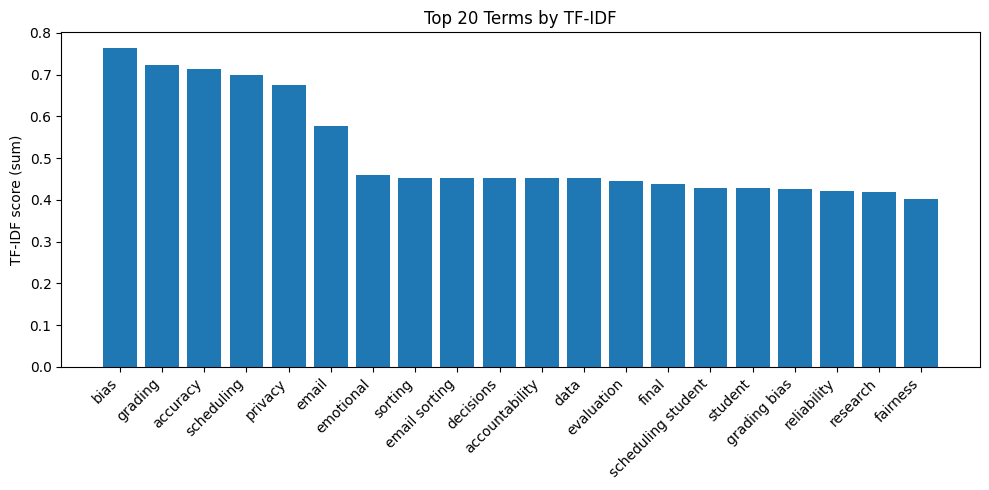

In [4]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=2000, ngram_range=(1,2))
X = vectorizer.fit_transform(df["combined_text"])

# sum TF-IDF per term across documents
tfidf_sum = np.asarray(X.sum(axis=0)).ravel()
terms = vectorizer.get_feature_names_out()
top_n = 20
top_idx = tfidf_sum.argsort()[::-1][:top_n]
top_terms = terms[top_idx]
top_scores = tfidf_sum[top_idx]

# Plot
plt.figure(figsize=(10,5))
plt.bar(top_terms, top_scores)
plt.xticks(rotation=45, ha="right")
plt.title(f"Top {top_n} Terms by TF-IDF")
plt.ylabel("TF-IDF score (sum)")
plt.tight_layout()
plt.show()


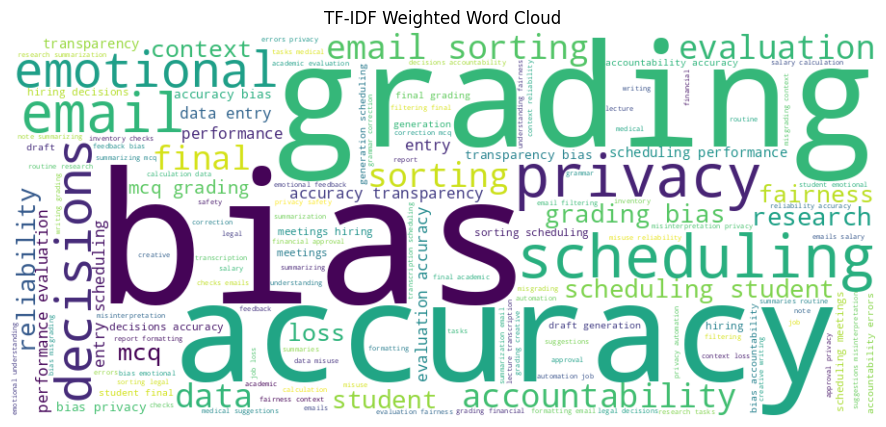

In [5]:
# Prepare frequency for WordCloud: use TF-IDF scores as weights
tfidf_dict = {term: float(tfidf_sum[i]) for i, term in enumerate(terms)}

wc = WordCloud(width=900, height=400, background_color="white", collocations=False)
wc.generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Weighted Word Cloud")
plt.show()


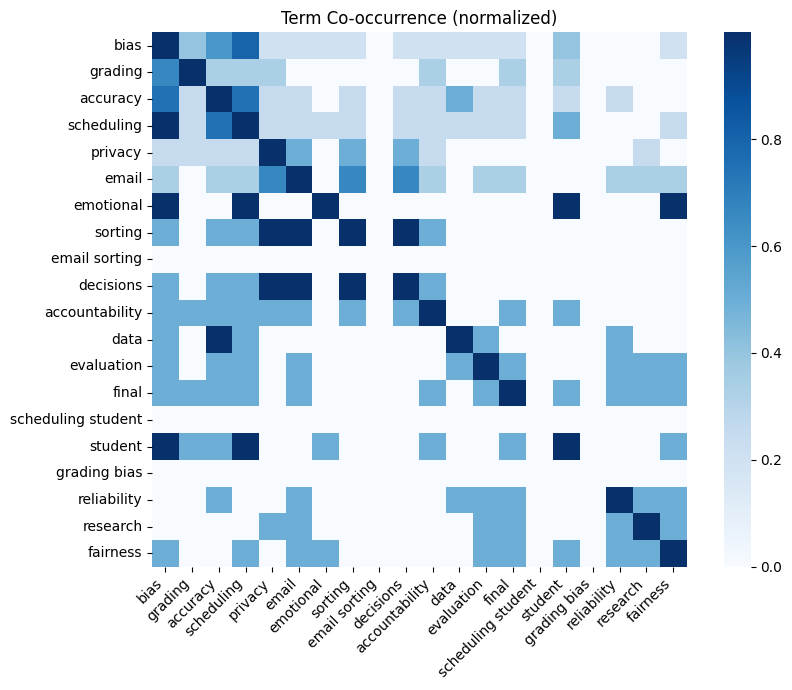

In [6]:
# Use CountVectorizer to compute co-occurrence of top terms
count_vect = CountVectorizer(vocabulary=top_terms, binary=True)
B = count_vect.fit_transform(df["combined_text"]).toarray()  # docs x top_terms

# co-occurrence matrix (term x term) = B.T @ B
cooc = np.dot(B.T, B)

# normalize by diagonal (optional)
cooc_norm = cooc / (np.diag(cooc)[:, None] + 1e-9)

plt.figure(figsize=(9,7))
sns.heatmap(cooc_norm, xticklabels=top_terms, yticklabels=top_terms, cmap="Blues", square=True)
plt.xticks(rotation=45, ha="right")
plt.title("Term Co-occurrence (normalized)")
plt.tight_layout()
plt.show()


In [7]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)

# KMeans (choose small k, e.g., 2 or 3)
k = 3
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(X_reduced)
df["cluster"] = labels

# show cluster sizes
print("Cluster sizes:", Counter(labels))

# show top terms per cluster (by centroid weight in original TF-IDF space)
centroids = km.cluster_centers_  # in reduced space
# approximate: project centroids back to original space (centroids * components)
approx_centroids = centroids.dot(svd.components_)
top_terms_per_cluster = {}
for i in range(k):
    idx = np.argsort(approx_centroids[i])[::-1][:8]
    top_terms_per_cluster[i] = [terms[j] for j in idx]

top_terms_per_cluster


Cluster sizes: Counter({np.int32(2): 5, np.int32(1): 3, np.int32(0): 2})


{0: ['research',
  'tasks medical',
  'misinterpretation privacy',
  'misinterpretation',
  'research tasks',
  'tasks',
  'suggestions',
  'safety'],
 1: ['grading',
  'grading bias',
  'mcq',
  'loss',
  'mcq grading',
  'bias',
  'accountability accuracy',
  'student final'],
 2: ['accuracy',
  'scheduling',
  'bias',
  'emotional',
  'sorting',
  'email sorting',
  'decisions',
  'data']}

In [8]:
# Save clustered dataset and top-term lists
df.to_csv("nlp_results_clustered.csv", index=False)
with open("top_terms_per_cluster.txt", "w", encoding="utf-8") as f:
    for cl, words in top_terms_per_cluster.items():
        f.write(f"Cluster {cl}: " + ", ".join(words) + "\n")
print("Saved nlp_results_clustered.csv and top_terms_per_cluster.txt")


Saved nlp_results_clustered.csv and top_terms_per_cluster.txt
